## Practical 9: Selecting Data

Selecting & Linking Data

> **Important**
>
> This practical focusses on data linkage! You will have seen quite a
> bit of this of these across the preceding three to four weeks, but
> they were picked up in an *ad-hoc* way, here we try to systematise
> things a bit.

> **🔗 Connections**
>
> We’re going to look at how data can be joined (linked) to other data
> using a range of techniques: pure Python (spatial and non-spatial) and
> SQL (non-spatial only).

## 1. Preamble

In [1]:
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet'

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
import os
from requests import get
from urllib.parse import urlparse
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src, dst, min_size=100):
        url = urlparse(src) # We assume that this is some kind of valid URL 
        fn  = os.path.split(url.path)[-1] # Extract the filename
        dsn = os.path.join(dst,fn) # Destination filename
        if os.path.isfile(dsn) and os.path.getsize(dsn) > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:str, dst:str) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """

    # Convert the path back into a list (without)
    # the filename -- we need to check that directories
    # exist first.
    path = os.path.split(dst)[0]
    print(f"Path: {path}")
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if path != '':
        os.makedirs(path, exist_ok=True)
        
    # Download and write the file
    with open(dst, "wb") as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst

In [4]:
ddir = os.path.join('data','geo') # destination directory
pqt  = cache_data(url, ddir)

+ data/geo/20240614-London-listings.geoparquet found locally!


## 2. Selecting Data

### 2.1 In Pandas

#### 2.1.1 A first query (Recap)

In [5]:
%%time 

pd.read_parquet(f'{pqt}').head(3) 

CPU times: user 579 ms, sys: 378 ms, total: 957 ms
Wall time: 1.27 s


,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,92644,https://www.airbnb.com/rooms/92644,2023-09-06,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,498201,Dee Dee,2011-04-10,"London, United Kingdom",False,...,42.0,2,730,217,216.0,2011-06-21,2022-10-29,4.57,1.45,b'\x01\x01\x00\x00\x00\xeax\xcc@e\xfc\xc7\xbf\...
1,93015,https://www.airbnb.com/rooms/93015,2023-09-06,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,499704,Sarah,2011-04-11,"London, United Kingdom",False,...,175.0,5,240,40,38.0,2012-02-01,2022-09-30,4.82,0.27,b'\x01\x01\x00\x00\x00\r\xabx#\xf3\xc8\xcb\xbf...
2,13913,https://www.airbnb.com/rooms/13913,2023-09-06,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,54730,Alina,2009-11-16,"London, United Kingdom",False,...,79.0,1,29,360,41.0,2010-08-18,2022-12-11,4.80,0.26,b'\x01\x01\x00\x00\x00\xeeZB>\xe8\xd9\xbc\xbf\...


This should (I hope) be trivial to read now: we are loading a parquet
file using pandas and taking advantage of Python’s ‘chaining’
functionality (`<object>.<method>().<method>()...`) to return the first
three rows using `head`. It is worth noticing that we’re not even
bothering to save the result of this command to a data frame (thus the
lack of a `df =` in the code) and We’re doing this here solely so that
you can compare pandas and SQL/DuckDB syntax across each of the
following steps.

#### 2.1.2 Choosing some columns (Recap)

To load a columnar subset of the data we have two options:

1.  Load all the data and *then* subset (which always happens with CSV
    files but is optional with other formats)
2.  Load only the columns we care about (which is possible with parquet
    files)

And in code these are:

##### 2.1.2.1 Load *then* filter

In [6]:
%%time

pd.read_parquet(f'{pqt}')[['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name']].head(5)

CPU times: user 419 ms, sys: 274 ms, total: 693 ms
Wall time: 884 ms


,listing_url,price,number_of_reviews,property_type,host_name
0,https://www.airbnb.com/rooms/92644,42.0,216.0,Private room in rental unit,Dee Dee
1,https://www.airbnb.com/rooms/93015,175.0,38.0,Entire rental unit,Sarah
2,https://www.airbnb.com/rooms/13913,79.0,41.0,Private room in rental unit,Alina
3,https://www.airbnb.com/rooms/15400,150.0,94.0,Entire rental unit,Philippa
4,https://www.airbnb.com/rooms/93734,46.0,180.0,Private room in condo,William


##### 2.1.2.2 Filter *then* load

In [7]:
%%time

pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name']).head(5)

CPU times: user 54.4 ms, sys: 10.9 ms, total: 65.4 ms
Wall time: 69.8 ms


,listing_url,price,number_of_reviews,property_type,host_name
0,https://www.airbnb.com/rooms/92644,42.0,216.0,Private room in rental unit,Dee Dee
1,https://www.airbnb.com/rooms/93015,175.0,38.0,Entire rental unit,Sarah
2,https://www.airbnb.com/rooms/13913,79.0,41.0,Private room in rental unit,Alina
3,https://www.airbnb.com/rooms/15400,150.0,94.0,Entire rental unit,Philippa
4,https://www.airbnb.com/rooms/93734,46.0,180.0,Private room in condo,William


Notice the difference in the time needed to complete the operation!!!

#### 2.1.3 Adding a constraint (Recap)

In [8]:
%%time 

df = pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'property_type', 'host_name'])
df[(df.price < 250) & (df.number_of_reviews > 0) & (df.property_type=='Entire home/apt')].head(5)

CPU times: user 67.1 ms, sys: 32.5 ms, total: 99.5 ms
Wall time: 117 ms


,listing_url,price,number_of_reviews,property_type,host_name
18922,https://www.airbnb.com/rooms/20296839,96.0,7.0,Entire home/apt,Lira
18975,https://www.airbnb.com/rooms/20349067,99.0,1.0,Entire home/apt,M
22319,https://www.airbnb.com/rooms/22959348,100.0,3.0,Entire home/apt,Robert
38944,https://www.airbnb.com/rooms/42969992,173.0,1.0,Entire home/apt,Duda
52418,https://www.airbnb.com/rooms/649784743352942906,91.0,9.0,Entire home/apt,Travelnest


For improved legibility you can also write this as:

``` python
df = pd.read_parquet(f'{pqt}', columns=['listing_url', 'price', 'number_of_reviews', 'last_review', 'host_name'])
df[
    (df.price < 250) & 
    (df.number_of_reviews > 0) & 
    (df.property_type=='Entire home/apt')
].head(5)
```

Notice here that we are using three conditions to filter the data *as
well as* a column filter on loading to minimise the amount of data
loaded into memory. Applying the filters simultaneously will also make
it easy to see what you’ve done (you aren’t applying each one
separately) and to adjust the overall cleaning process.

This filter is fairly straightforward, but things get more complicated
when you want to aggregate the return…

#### 2.1.4 Aggregating the return

There is a *lot* to unpack here, and notice that it takes three steps to
achieve our goal of selecting, grouping, aggregating, sorting, and
printing out the ten most frequent combinations of room and property
type.

In [9]:
%%time 
# 读取、过滤、分组
# 聚合（计算每组的 property_type 出现次数 和 price 中位数）
# 重置索引、排序
df = pd.read_parquet(f'{pqt}', columns=['property_type','room_type','number_of_reviews','price'])
df = df[
    (df.price < 1050) & 
    (df.number_of_reviews > 0)
]
df.groupby(
        by=['room_type','property_type'],
        observed=True
    ).agg(
        freq = ("property_type", "count"),
        median_price = ("price", "median"),
).reset_index().sort_values(
        by=['freq','room_type','property_type'], ascending=[False,True,True]
    ).head(10)

CPU times: user 27.9 ms, sys: 1.66 ms, total: 29.5 ms
Wall time: 34.9 ms


,room_type,property_type,freq,median_price
18,Entire home/apt,Entire rental unit,24662,136.0
68,Private room,Private room in rental unit,9763,52.0
59,Private room,Private room in home,7800,49.0
10,Entire home/apt,Entire condo,7542,156.0
14,Entire home/apt,Entire home,5243,200.0
52,Private room,Private room in condo,2883,67.0
19,Entire home/apt,Entire serviced apartment,1565,200.0
72,Private room,Private room in townhouse,1205,55.0
20,Entire home/apt,Entire townhouse,967,235.0
45,Private room,Private room in bed and breakfast,412,78.0


Hopefully the first two steps are fairly clear, so let’s focus on the
final one:

##### 2.1.4.1 Group By

This is a *reasonably* intelligible step in which we group the data
loaded by room and property:

``` python
dfg = df.groupby(
        by=['room_type','property_type'],
        observed=True
    )
dfg
```

The *order* here matters: `groupby(by=[<A>,<B>])` does not return the
same result as `groupby(by=[<B>,<A>])`. Try it:

``` python
df.groupby(
        by=['property_type','room_type'],
        observed=True
    )
```

The other thing to note here is the `observed=True`. This is a nice bit
of additional functionality that, if you set it to `False` will return a
number for all possible combinations, inserting a zero if that
combintaion is *not* observed in the data.

##### 2.1.4.2 Agg

The `agg` step aggregates the data specified in the functions:

``` python
dfg.agg(
        freq = ("property_type", "count"),
        median_price = ("price", "median"),
)
```

Pandas offers a *lot* of different ways to do this, but the above
approach is perhaps the most flexible since we are telling Pandas to
apply the `count` function to the `property_type` field and assign it to
a column called `freq`, and to apply the `median` function to the
`price` field and assign that to a column called `median_price`.

##### 2.1.4.3 ‘Degroup’

In order to work with the aggregated data you will *almost* always want
to convert your `GroupedDataFrame` back to a regular `DataFrame` and
that means resetting the index `reset_index()` – this is just one of
those things to learn about grouped data in Pandas.

##### 2.1.4.4 Sort

Finally, to sort the *data* (which is usually what you want) you need to
`sort_values`, where `by` specifies the fields you want to sort on and
`ascending` is a matching (optional) list that specifies the sort order
for each sort column. If you just want to sort everything in ascending
order then you don’t need to specify the `ascending` values, and if you
wanted to sort *everything* in descending order then it’s just
`ascending=False`.

### 2.2 In SQL

That last example may have left you despairing of every being able to
select/filter/aggregate/derive your data, but there *is* another way
that is often far simpler *if* you are: a) willing to learn a different
language, and b) willing to work with data in different formats. And
that’s all thanks to Parquet and DuckDB.

#### 2.2.1 Parquet and DuckDB

One of the recent technical *revolutions* that has fundamentally
reshaped my workflow is the combination of parquet files and in-memory
databases. Parquet and Apache Arrow are [closely
related](https://stackoverflow.com/a/56481636) but, in short, when you
want to save large data sets in an easy-to-access format then Parquet
should be your default choice. DuckDB gives you a way to treat Parquet
files *as* a database **table** and run queries against it using
standard SQL. You can [install DuckDB](https://duckdb.org/#quickinstall)
on the command-line, but you can also query it from within Python using
the appropriate module.

#### 2.2.2 A first query

Let’s see a quick demonstration:

In [12]:
%%time 

import duckdb as db

# 定义 SQL 查询语句
# 选择所有列
# 读取 Parquet 文件
# 返回前三行
query = f''' 
SELECT *
FROM read_parquet('{pqt}') 
LIMIT 3;
'''
# 将查询结果转换为 dataframe
db.sql(query).to_df()

CPU times: user 722 ms, sys: 28.3 ms, total: 750 ms
Wall time: 703 ms


,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,92644,https://www.airbnb.com/rooms/92644,2023-09-06,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,498201,Dee Dee,2011-04-10,"London, United Kingdom",False,...,42.0,2,730,217,216.0,2011-06-21,2022-10-29,4.57,1.45,"[1, 1, 0, 0, 0, 234, 120, 204, 64, 101, 252, 1..."
1,93015,https://www.airbnb.com/rooms/93015,2023-09-06,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,499704,Sarah,2011-04-11,"London, United Kingdom",False,...,175.0,5,240,40,38.0,2012-02-01,2022-09-30,4.82,0.27,"[1, 1, 0, 0, 0, 13, 171, 120, 35, 243, 200, 20..."
2,13913,https://www.airbnb.com/rooms/13913,2023-09-06,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,54730,Alina,2009-11-16,"London, United Kingdom",False,...,79.0,1,29,360,41.0,2010-08-18,2022-12-11,4.80,0.26,"[1, 1, 0, 0, 0, 238, 90, 66, 62, 232, 217, 188..."


And now let’s unpack this:

1.  We import the `duckdb` library as `db`.
2.  We set up a SQL `query` using a multi-line f-string
3.  We use DuckDb to execute the query and return a pandas dataframe
    (`df`)

What’s particularly elegant here (and quite different from trying to
talk to a Postres or MySQL database) is that there’s no
connect-execute-collect pattern; we just build the query and execute it!

#### 2.2.3 Deciphering SQL

> **I *do* declare…**
>
> Now let’s take a look at the SQL query… SQL is what’s called a
> [declarative
> language](https://en.wikipedia.org/wiki/Declarative_programming),
> meaning that it is about the logic we want the program to follow
> rather than the ‘flow’ of execution. Python supports *some*
> declarative elements but is more commonly seen as an imperative
> language supporting procedural or functional approaches. This is a
> long way of saying: SQL won’t look like Python even though we’re
> executing SQL from *within* Python.

So our query (with added line numbers for clarity) looked liked this:

``` sql
SELECT *
FROM read_parquet('{pqt}') 
LIMIT 3
```

Line-by-line this means:

1.  Select all columns (`SELECT <* == everything>`)
2.  From the parquet file (`FROM <table location>`)
3.  Limit the return to 3 rows (`LIMIT <row count>`)

Let’s look at some variations…

#### 2.2.4 Choosing some columns

In [13]:
%%time 

# 选择特定列
# 读取 Parquet
# 返回前五行
query = f'''
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
LIMIT 5;
'''

db.sql(query).to_df()

CPU times: user 105 ms, sys: 21.1 ms, total: 127 ms
Wall time: 134 ms


,listing_url,price,number_of_reviews,last_review,host_name
0,https://www.airbnb.com/rooms/92644,42.0,216.0,2022-10-29,Dee Dee
1,https://www.airbnb.com/rooms/93015,175.0,38.0,2022-09-30,Sarah
2,https://www.airbnb.com/rooms/13913,79.0,41.0,2022-12-11,Alina
3,https://www.airbnb.com/rooms/15400,150.0,94.0,2023-05-01,Philippa
4,https://www.airbnb.com/rooms/93734,46.0,180.0,2023-09-02,William


``` sql
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
LIMIT 5;
```

It should be fairly easy to see how the query has changed from last
time, but line-by-line this means:

1.  Select a set of columns from the table in the order specified
    (`SELECT <column 1>, <column 30>, <column 5>...`)
2.  From the parquet file (`FROM <table location>`)
3.  Limit the return to 5 rows (`LIMIT <row count>`)

#### 2.2.5 Adding a constraint

In [14]:
%%time

# 使用 WHERE 添加三个约束
query = f'''
SELECT listing_url, price, number_of_reviews, last_review, host_name 
FROM read_parquet('{pqt}') 
WHERE price < 250 
AND number_of_reviews > 0
AND property_type='Entire home/apt'
LIMIT 5;
'''

db.sql(query).to_df()

CPU times: user 178 ms, sys: 47.9 ms, total: 226 ms
Wall time: 230 ms


,listing_url,price,number_of_reviews,last_review,host_name
0,https://www.airbnb.com/rooms/20296839,96.0,7.0,2017-10-01,Lira
1,https://www.airbnb.com/rooms/20349067,99.0,1.0,2017-11-12,M
2,https://www.airbnb.com/rooms/22959348,100.0,3.0,2018-02-04,Robert
3,https://www.airbnb.com/rooms/42969992,173.0,1.0,2021-10-24,Duda
4,https://www.airbnb.com/rooms/649784743352942906,91.0,9.0,2023-03-22,Travelnest


In this query we’ve added *three* constraints using a `WHERE`, which is
asking DuckDB to find all of the rows *where* the following things are
true:

1.  The `price` must be less than (\$)250/night
2.  The `number_of_reviews` must be more than 0
3.  The `property_type` must be `Entire home/apt`

#### 2.2.6 Aggregating the return

So far, we’ve seen a few ways (and hopefully enough to get you started)
to *select* data, but databases also ‘excel’ at aggregating data in
various ways. We aren’t going to get into things like windowing
functions or stored procedures here, but even simple aggregates done in
DuckDB can vastly improve on the performance of pandas.

> **Tip**
>
> When you aggregate data you need to retrieve *every* column in the
> `SELECT` portion that you `GROUP BY` in the `WHERE` portion of the
> query. This will make sense when you see the examples below… (and
> should also make sense based on the Pandas equivalent above)

In [15]:
%%time

# 添加 GROUP BY 聚合和 ORDER BY 排序
query = f'''
SELECT property_type, room_type, COUNT(*) AS frequency, MEDIAN(price) 
FROM read_parquet('{pqt}') 
WHERE price < 1000 
AND number_of_reviews > 0
GROUP BY room_type, property_type
ORDER BY frequency DESC, room_type, property_type
LIMIT 10;
'''

db.sql(query).to_df()

CPU times: user 118 ms, sys: 19.3 ms, total: 138 ms
Wall time: 127 ms


,property_type,room_type,frequency,median(price)
0,Entire rental unit,Entire home/apt,24634,136.0
1,Private room in rental unit,Private room,9754,52.0
2,Private room in home,Private room,7797,49.0
3,Entire condo,Entire home/apt,7532,155.0
4,Entire home,Entire home/apt,5228,200.0
5,Private room in condo,Private room,2880,67.0
6,Entire serviced apartment,Entire home/apt,1565,200.0
7,Private room in townhouse,Private room,1204,55.0
8,Entire townhouse,Entire home/apt,964,234.5
9,Private room in bed and breakfast,Private room,412,78.0


There are quite a few changes to the query here so it’s worth reviewing
them in more detail:

``` sql
SELECT property_type, room_type, COUNT(*) AS frequency, MEDIAN(price) 
FROM read_parquet('{pqt}') 
WHERE price < 1000 
AND number_of_reviews > 0
GROUP BY room_type, property_type
ORDER BY frequency DESC, room_type, property_type
LIMIT 10;
```

Key things to note:

1.  We have two new aggregate *functions*:
    -   `COUNT(*)` returns a count of the number of rows in each group
        specified in the `GROUP BY` clause.
    -   `MEDIAN(price)` returns, unsurprisingly, the median value of the
        `price` column for each group specified in the `GROUP BY`
        clause.
    -   *Note* also the `AS frequency` which ‘renames’ the column
        returned by the query; it’s the same concept as the
        `import x as y` in Python.
2.  `GROUP BY` is where the aggregation happens, and here we’re asking
    DuckDB to take all of the rows selected
    (`WHERE price < 1000 AND number_of_reviews > 0`) and group them
    using the `room_type` and `property_type` fields.
3.  `ORDER BY` orders the returned records by the columns we specify,
    and they can be either `ASC`ending (the default) or `DESC`ending
    (descending).

What you should also be noting here is that:

-   This query returns *very* quickly compared to the pandas equivalent.
-   We have been able to express our selection, grouping, and organising
    criteria very succinctly.

In terms of both speed and intelligibility, there can be quite
substantial advantages to moving *some* of your workflow into a database
or a database-like format such as Parquet and then querying that from
Python. Databases are *designed* for the kind of application that Pandas
struggles with, and if you get to windowing functions and stored
procedures you’ll see how there are situations where something is far
easier to express in Python/Pandas than in SQL.

So the trick here is to recognise when you are facing a problem that: a)
will benefit from being expressed/tackled in a different language; and
b) won’t create undue overhead on your technology ‘stack’. In working
with environmental and built environment data I was able to cut the
processing time by 80% when I moved the bulk of the data linkage work
from Pandas into Parquet+DuckDB. *But*, by the same token, what’s the
point of using Postgres and managing a spatial database to perform a
single step in a much longer workflow *unless* the performance
considerations are so massive they outweigh any other issue.

## 3. Non-Spatial Joins

We’re going to look at joining data by attributes *first* and then look
at spatial joins so that you get a sense of how they behave and differ.

For non-spatial joins we only need two data sets relating to MSOAs:

In [16]:
msoa_names_url = 'https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-1.20.csv'
msoa_popst_url = 'https://orca.casa.ucl.ac.uk/~jreades/data/sapemsoaquinaryagetablefinal.xlsx'

msoa_df = pd.read_excel(msoa_popst_url, sheet_name="Mid-2022 MSOA 2021", header=3)
msoa_nms = pd.read_csv( cache_data(msoa_names_url, 'data') )

# For DuckDB
if not os.path.exists('data/MSOA_population_estimates.parquet'):
    msoa_df.to_parquet('data/MSOA_population_estimates.parquet')

print(f"msoa_df  has {msoa_df.shape[0]:,} rows and {msoa_df.shape[1]:,} columns.")
print(f"msoa_nms has {msoa_nms.shape[0]:,} rows and {msoa_nms.shape[1]:,} columns.")

+ data/MSOA-Names-1.20.csv not found, downloading!
Path: data
 + Done downloading...
msoa_df  has 7,264 rows and 43 columns.
msoa_nms has 7,201 rows and 6 columns.


> **The preferred solution**
>
> To keep it simple: you should assume that non-spatial joins are
> *always* going to be faster than spatial ones, even in a performant
> spatial database. Asking if one number is less than another, or if a
> piece of text is found in another piece of text, is *much* simpler
> than asking if one object falls within the boundaries of another.
> Spatial databases are fast and very cool, but if you can express your
> problem non-spatially it will be faster to solve it that way too.

### 3.1 In Pandas

Pandas distinguishes between several types of what SQL would call a
‘join’: the process of linking two data sets. Depending on what you want
to do, this will fall into one of the [merge, join, concatenate, or
compare](https://pandas.pydata.org/docs/user_guide/merging.html)
functions:

-   `concat` simply appends one data frame to another and won’t be
    discussed further, but keep in mind that you can concatenate
    horizontally and vertically (across and down), and that having named
    indexes can cause consternation. You would find it most useful for
    appending columns to a data set (appending rows should be approached
    differently) or extending a data set for year $n$ with data from
    year $n+1$…
-   `merge` is what we normally want when we want to do something
    similar to a SQL join. You should refer back to the lecture for the
    differences between ‘one-to-one’, ‘one-to-many’, and ‘many-to-many’.
    Note too that merging is a function of the pandas library and *not*
    a method of a data frame.

#### 3.1.1 Joining by attribute

So in our case, to join the two MSOA data sets we’re going to need to
match the MSOA codes which have (slightly) different names in the two
datasets:

In [17]:
%%time
# 根据 msoa code 进行左连接
rs = pd.merge(msoa_df, msoa_nms[['msoa11cd','msoa11hclnm','Laname']], left_on='MSOA 2021 Code', right_on='msoa11cd', how='left')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(3)

Result set has 7,264 rows and 46 columns.
CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 33.5 ms


,LAD 2021 Code,LAD 2021 Name,MSOA 2021 Code,MSOA 2021 Name,Total,F0 to 4,F5 to 9,F10 to 14,F15 to 19,F20 to 24,...,M60 to 64,M65 to 69,M70 to 74,M75 to 79,M80 to 84,M85 to 89,M90 and over,msoa11cd,msoa11hclnm,Laname
0,E06000001,Hartlepool,E02002483,Hartlepool 001,10323,265,296,356,302,238,...,281,254,210,180,93,82,28,E02002483,Clavering,Hartlepool
1,E06000001,Hartlepool,E02002484,Hartlepool 002,10460,325,349,295,340,283,...,363,276,248,175,86,49,28,E02002484,Headland & West View,Hartlepool
2,E06000001,Hartlepool,E02002485,Hartlepool 003,8040,238,287,295,262,225,...,272,198,159,143,61,31,12,E02002485,Jesmond,Hartlepool


**But wait!** There’s an issue lurking in the data!

In [18]:
print(f"There are {rs.msoa11hclnm.isna().sum()} missing MSOA Names!")

There are 184 missing MSOA Names!


Can you work out why this has happened? There is a clue in the column
names!

There’s no way to solve this problem except by changing the code to use
[this URL
instead](https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-Latest2.csv)
for the MSOA Names.

We can also try to constrain the result set to one LA thanks to data in
the MSOA Names database:

In [19]:
%%time 
# 通过内连接获得 LA 的数据
la_nm = 'Waltham Forest'
sdf   = msoa_nms[msoa_nms.Laname==la_nm][['msoa11cd','msoa11hclnm','Laname']].copy()

rs = pd.merge(msoa_df, sdf, left_on='MSOA 2021 Code', right_on='msoa11cd', how='inner')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(3)

Result set has 28 rows and 46 columns.
CPU times: user 10 ms, sys: 1.41 ms, total: 11.5 ms
Wall time: 16.2 ms


,LAD 2021 Code,LAD 2021 Name,MSOA 2021 Code,MSOA 2021 Name,Total,F0 to 4,F5 to 9,F10 to 14,F15 to 19,F20 to 24,...,M60 to 64,M65 to 69,M70 to 74,M75 to 79,M80 to 84,M85 to 89,M90 and over,msoa11cd,msoa11hclnm,Laname
0,E09000031,Waltham Forest,E02000895,Waltham Forest 001,8363,208,233,250,228,215,...,242,209,153,194,137,93,45,E02000895,Chingford Green West,Waltham Forest
1,E09000031,Waltham Forest,E02000896,Waltham Forest 002,9322,256,278,264,230,241,...,257,218,216,190,111,111,54,E02000896,Chingford Green East,Waltham Forest
2,E09000031,Waltham Forest,E02000897,Waltham Forest 003,8438,233,262,276,212,209,...,205,162,136,98,104,87,24,E02000897,Friday Hill,Waltham Forest


Without the `how=inner`, the result set would still have all of the rows
but some of the columns would be nearly completely empty.

### 3.2 In SQL

SQL-based joins use very similar keywords (since Pandas is copying SQL),
but how we put together the query is quite different.

#### 3.2.1 Joining by attribute

In [20]:
%%time
# 选择所有列
# 读取 Parquet 文件命名为 n
# 读取 CSV 文件路径，命名为 m
# 使用左连接将两表按 code 匹配
query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
LEFT JOIN 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd;
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 121 ms, sys: 67.4 ms, total: 188 ms
Wall time: 785 ms


,LAD 2021 Code,LAD 2021 Name,MSOA 2021 Code,MSOA 2021 Name,Total,F0 to 4,F5 to 9,F10 to 14,F15 to 19,F20 to 24,...,M75 to 79,M80 to 84,M85 to 89,M90 and over,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
0,E09000001,City of London,E02000001,City of London 001,10847,105,78,69,191,699,...,143,86,36,22,E02000001,City of London 001,City of London 001,City of London,None,City of London
1,E09000002,Barking and Dagenham,E02000002,Barking and Dagenham 001,8384,350,346,392,322,211,...,108,71,29,29,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,Marks Gate,None,Barking and Dagenham
2,E09000002,Barking and Dagenham,E02000003,Barking and Dagenham 002,11803,494,431,359,330,372,...,125,91,40,19,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,Chadwell Heath East,None,Barking and Dagenham


> **Slower???**
>
> *Without* the data caching function, the query above may *appear*
> slower than the Pandas one but if you look at the timing information
> you’ll see that the actual time spent processing the data was less.
> How can that be? Notice that above we’re reading the CSV file from the
> House of Commons library as *part* of the join, so most of that delay
> is spent waiting for the CSV file to download! Another reason is that
> the files aren’t being loaded into memory *first*, but are being read:
> on small files this allows pandas to outperform DuckDB, but as the
> file size grows the performance profile will change radically.
>
> Anyway, the download penalty is why I prefer to download a file *once*
> and save it locally rather than downloading the same file again and
> again. Plus it’s friendlier (and cheaper!) to the person or
> organisation providing the data to you.

Let’s take a look at the SQL:

``` sql
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
LEFT JOIN 
    read_csv(msoa_names_url, header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd;
```

Line-by-line:

1.  `SELECT` every column (this is the `*`, change this if you want to
    only pull a subset of columns)
2.  `FROM` the following tables (it doesn’t really matter if the tables
    are on this line or the next for legibility)
3.  `<table 1 from parquet> as n` (we now refer to the data from this
    table using the prefix `n.`; e.g. `n.Total`)
4.  `LEFT JOIN` is the SQL way of saying to keep all of the rows in the
    first table (`n`, which is the first, and therefore ‘left’ table)
5.  `<table 2 from csv> as m` (we now refer to the data from this table
    using the prefix `m.`; e.g. `m.geometry`)
6.  `ON <left table matching column> = <right table matching column>`
    (here, the unusual thin is the double-quotes around the column name
    required to deal with the fact that the label contains spaces).

*Notice* how there are parallels between even quite different languages
here: if you have spaces or special characters or whatever in your
column name then you’re going to need to handle that a little
differently, and if you have two tables to join you have a left (aka
first) one and a right (aka second) one and the order matters.

Now, running the same query to get the Waltham Forest data can be done
two ways:

In [23]:
%%time
# 获取 Waltham Forest 数据
# INNER JOIN 显式连接，连接条件 ON 和过滤条件 WHERE 分开
boro = 'Waltham Forest'
query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n 
INNER JOIN 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
ON 
    n."MSOA 2021 Code"=m.msoa11cd
WHERE 
    m.Laname='{boro}';
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 763 ms, sys: 34.3 ms, total: 797 ms
Wall time: 849 ms


,LAD 2021 Code,LAD 2021 Name,MSOA 2021 Code,MSOA 2021 Name,Total,F0 to 4,F5 to 9,F10 to 14,F15 to 19,F20 to 24,...,M75 to 79,M80 to 84,M85 to 89,M90 and over,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
0,E09000031,Waltham Forest,E02000895,Waltham Forest 001,8363,208,233,250,228,215,...,194,137,93,45,E02000895,Waltham Forest 001,Waltham Forest 001,Chingford Green West,None,Waltham Forest
1,E09000031,Waltham Forest,E02000896,Waltham Forest 002,9322,256,278,264,230,241,...,190,111,111,54,E02000896,Waltham Forest 002,Waltham Forest 002,Chingford Green East,None,Waltham Forest
2,E09000031,Waltham Forest,E02000897,Waltham Forest 003,8438,233,262,276,212,209,...,98,104,87,24,E02000897,Waltham Forest 003,Waltham Forest 003,Friday Hill,None,Waltham Forest


Everything here is *basically* the same except for:

1.  We changed the `LEFT JOIN` to an `INNER JOIN` – this should make
    sense to you if you’ve watched the lectures.
2.  We added a `WHERE m.Laname=<borough name>` which restricts the match
    to only those rows where the Local Authority name is Waltham Forest.

*However*, note that this query can *also* be written this way:

In [24]:
%%time
# 逗号分隔两表，隐式连接
# 连接和过滤条件都写在 WHERE 中
boro = 'Waltham Forest'
query = f'''
SELECT * 
FROM 
    read_parquet('data/MSOA_population_estimates.parquet') as n, 
    read_csv('{cache_data(msoa_names_url, 'data')}', header=true) as m
WHERE m.Laname='{boro}'
AND n."MSOA 2021 Code"=m.msoa11cd;
'''

db.sql(query).to_df().head(3)

+ data/MSOA-Names-1.20.csv found locally!
CPU times: user 665 ms, sys: 59.8 ms, total: 725 ms
Wall time: 721 ms


,LAD 2021 Code,LAD 2021 Name,MSOA 2021 Code,MSOA 2021 Name,Total,F0 to 4,F5 to 9,F10 to 14,F15 to 19,F20 to 24,...,M75 to 79,M80 to 84,M85 to 89,M90 and over,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
0,E09000031,Waltham Forest,E02000895,Waltham Forest 001,8363,208,233,250,228,215,...,194,137,93,45,E02000895,Waltham Forest 001,Waltham Forest 001,Chingford Green West,None,Waltham Forest
1,E09000031,Waltham Forest,E02000896,Waltham Forest 002,9322,256,278,264,230,241,...,190,111,111,54,E02000896,Waltham Forest 002,Waltham Forest 002,Chingford Green East,None,Waltham Forest
2,E09000031,Waltham Forest,E02000897,Waltham Forest 003,8438,233,262,276,212,209,...,98,104,87,24,E02000897,Waltham Forest 003,Waltham Forest 003,Friday Hill,None,Waltham Forest


The second way is a little easier to read, but it *only* allows you to
do **inner joins** where attributes need to match in both tables for a
row to be kept. This situation is such a common ‘use case’ that it makes
sense to have this simpler syntax, but the previous code will work for
inner, left, right, and outer joins.

## 4. Spatial Joins

> **Spatial DuckDB**
>
> DuckDB also now supports spatial queries via the [`SPATIAL`
> extension](https://duckdb.org/docs/extensions/spatial.html).
> Performance is *not* that of a tuned Postgres+PostGIS database, but
> the overhead of *creating* such a tuned database often exceeds the
> benefit for ad-hoc querying. Basically, Postgres+PostGIS is great if
> you’re a company such as Booking.com, Airbnb, or OpenStreetMap, but
> it’s most likely overkill for offline read-oriented applications.

### 4.1 Why obvious is not always right (Part 432)

Building on what I said above in
<a href="#sec-nonspatial" class="quarto-xref">Section 3</a>, even where
you *do* have a spatial challenge, it can be worth it to convert it to a
non-spatial solution to improve the overall performance of your code.
For instance, say you have data from LSOAs and want to be able to
aggregate it up to MSOAs and Boroughs to perform various analyses.

##### 4.1.0.1 LSOA Table

| LSOA Code | Polygon |
|----------:|--------:|
|     LSOA1 |  WKT(…) |
|     LSOA2 |  WKT(…) |
|     LSOA3 |  WKT(…) |

##### 4.1.0.2 MSOA Table

| MSOA Code | Polygon |
|----------:|--------:|
|     MSOA1 |  WKT(…) |
|     MSOA2 |  WKT(…) |
|     MSOA3 |  WKT(…) |

##### 4.1.0.3 Borough Table

| Borough Code | Polygon |
|-------------:|--------:|
|        BORO1 |  WKT(…) |
|        BORO2 |  WKT(…) |
|        BORO3 |  WKT(…) |

The *obvious* way to do this is as a spatial join:
`select all LSOAs within an MSOA and aggregate them`. And you would then
run this same query for every dimension you want to aggregate. **This is
*not* the right way to tackle this problem** even though you can write
the query to give you the correct answer.

The *right* way when you are going to repeatedly run an expensive
spatial query is to work out if you can ‘cache’ the result to save time
in the future. In this case the answer is to create a ‘lookup table’
which uses the LSOA and MSOA and Borough codes to tell you if a LSOA
falls inside a borough or MSOA. You perform the hard spatial query *just
once* to create the lookup table, and thereafter you are using a fast
non-spatial query.

In this case your lookup table will be this…

##### 4.1.0.4 Lookup Table

| LSOA Code | MSOA Code | Borough Code |
|----------:|----------:|-------------:|
|     LSOA1 |     MSOA1 |        BORO1 |
|     LSOA2 |     MSOA1 |        BORO1 |
|     LSOA3 |     MSOA2 |        BORO1 |

Now you can do any kind of *spatial aggregation* you want without having
to incur the costs of running a *spatial query* using something like:

``` sql
SELECT m."MSOA Code", SUM(<attribute>) as feature_sum, COUNT(<attribute 2>) as feature_count  
FROM <lsoa data table> as l, <lookup table> as lkp  
WHERE l."LSOA Code" = lkp."LSOA Code" 
GROUP BY lkp."MSOA Code";
```

See, no need for a spatial query and you can run the same query easily
for many features. You can also use this as a foundation for creating a
`VIEW` or a `MATERIALIZED VIEW`, but that’s an advanced topic for
managing your data more efficiently in an operational environment rather
than a research-oriented one.

But first, we need some actual geodata to work with:

In [25]:
msoa_gpkg = gpd.read_file( cache_data(f'{host}/~jreades/data//MSOA-2011.gpkg', ddir) ).to_crs('epsg:27700')
listings  = gpd.read_parquet( cache_data(f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet', ddir) ).to_crs('epsg:27700')

+ data/geo/MSOA-2011.gpkg not found, downloading!
Path: data/geo
 + Done downloading...
+ data/geo/20240614-London-listings.geoparquet found locally!


### 4.2 In Geopandas

Let’s try to find all of the listings that fall within the borough of
Waltham Forest, so that implies two steps:

1.  Subset the MSOA geo-data so that it only includes the Waltham Forest
    MSOAs.
2.  Run a spatial query to find the listings that are within those MSOAs
    (we could, optionally, `union` the MSOAs to get the outline of the
    borough)

<Axes: >

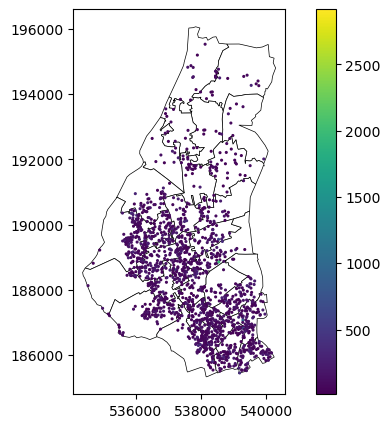

In [26]:
boro = 'Waltham Forest'
boro_gdf = msoa_gpkg[msoa_gpkg.LAD11NM==boro].copy()

# Do the spatial join
boro_listings = gpd.sjoin(listings, boro_gdf, predicate='within', rsuffix='_r')

# Layer the plots
f, ax = plt.subplots(1,1,figsize=(8,5))
boro_gdf.plot(color="white", edgecolor="black", linewidth=0.5, ax=ax)
boro_listings.plot(column='price', cmap='viridis', legend=True, s=1.5, aspect=1, ax=ax)

> **Warning**
>
> If you get `ValueError: aspect must be finite and positive` when you
> try to make a plot (this seems fairly common with GeoPackages (`.gpkg`
> files) then you will need to specify `aspect=1` in the `plot(...)`
> command.

### 4.3 In SQL

After quite a bit of faff my conclusion is that, while you *can* do
spatial queries in DuckDB it is a lot of work and *probably* not worth
the effort *at this time*. The ‘issue’ is that spatial support (as well
as Excel supprt) is provided via the `GDAL` framework and this takes
quite a different approach. After working it out, spatial queries do
work *fairly* well if you do them *entirely* within DuckDB (reading,
merging, and writing the data) and then load the results in a separate
step using GeoPandas; however, you *cannot* get a GeoDataFrame back via
`db.query(<query>).to_df()` since that only returns a Pandas data frame
and the geometry column is unreadable. In addition, geoparquet support
seems limited while GeoPackage performance is *poor*, so you’re
basically losing all the advantages of a parquet-based workflow.

So the examples below are provided for reference only and, on the whole,
right now I’d recommend using GeoPandas and geoparquet files directly.

+ data/geo/MSOA-2011.gpkg found locally!
+ data/MSOA-Names-1.20.csv found locally!
Result set has 28 rows and 4 columns.
CPU times: user 2.05 s, sys: 328 ms, total: 2.37 s
Wall time: 1.34 s


<Axes: >

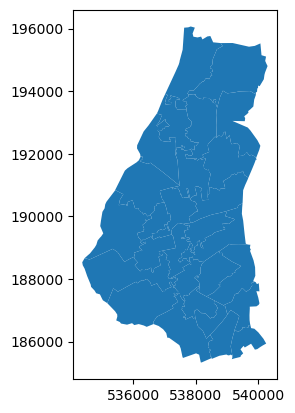

In [30]:
%%time

boro = 'Waltham Forest'

query = f'''
LOAD SPATIAL;
COPY(
  SELECT m.MSOA11CD, n.msoa11nm, n.Laname, m.geom 
  FROM 
      (SELECT MSOA11CD, geom FROM ST_Read("{cache_data(f'{host}/~jreades/data/MSOA-2011.gpkg', ddir)}")) AS m,
      read_csv("{cache_data(msoa_names_url, 'data')}") AS n
  WHERE m.MSOA11CD=n.msoa11cd
  AND n.Laname='{boro}'
) TO 'data/geo/merged.gpkg' WITH (FORMAT GDAL, DRIVER 'GPKG', LAYER_CREATION_OPTIONS 'WRITE_BBOX=YES');
'''

db.sql(query)
rs = gpd.read_file('data/geo/merged.gpkg')
print(f"Result set has {rs.shape[0]:,} rows and {rs.shape[1]:,} columns.")
rs.head(5)
rs.plot(aspect=1)

## 5. Worked Example

With that background material, let’s now work through a practical
example.

### 5.1 Load Geodata

A lot of useful geo-data can be accessed from the
[GeoPortal](https://geoportal.statistics.gov.uk/). And see also [my
discussion](https://jreades.github.io/fsds/sessions/week8.html) on
[lookup
tables](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-november-2018-lookup-in-the-uk-2/about).

In [31]:
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )
msoas = gpd.read_file( cache_data(f'{host}/~jreades/data/MSOA-2011.gpkg', ddir) ).to_crs('epsg:27700')

+ data/geo/Water.gpkg not found, downloading!
Path: data/geo
 + Done downloading...
+ data/geo/Boroughs.gpkg not found, downloading!
Path: data/geo
 + Done downloading...
+ data/geo/Greenspace.gpkg not found, downloading!
Path: data/geo
 + Done downloading...
+ data/geo/MSOA-2011.gpkg found locally!


### 5.2 Select London MSOAs

> **🔗 Connections**
>
> One thing to remember here is that computers are *exact*. So if you
> say that the selection should only be of MSOAs *within* London then
> you actually need to think about whether a shared border qualifies as
> ‘within’. Watch [the
> lectures](https://jreades.github.io/fsds/sessions/week10.html#lectures)
> again if you’re unsure, but that’s why here we take this slightly
> clunk approach of buffering the London boundary *before* doing the
> selection.

#### 5.2.1 Union

As we don’t have a boundary file for London, we can *generate* use using
the `unary_union` operator (as we do here) or using the
[dissolve()](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)
approach. Consider the pros and cons of each approach in terms of
performance, output format, and leigibility.

So here’s approach 1, which is a method call returning a GeoDataFrame
(which is why we can call `plot`):

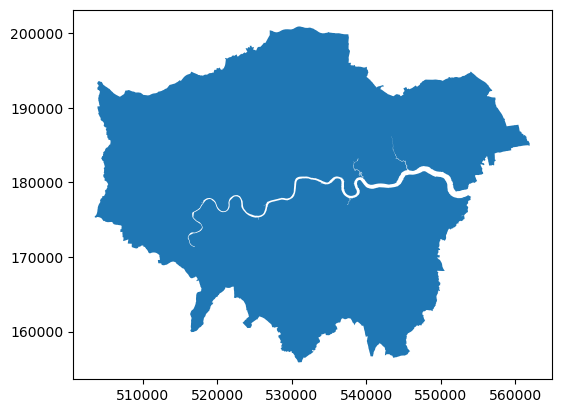

In [33]:
# dissolve()合并几何对象
boros.dissolve().plot();

And here’s approach 2, which is an *attribute* and returns a raw polygon
(so no reason to call `plot`, but it’s come back without the rest of the
data frame!):

/tmp/ipykernel_171/754193658.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boros.unary_union


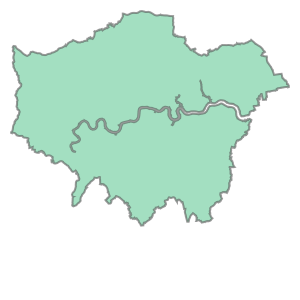

In [35]:
# unary_union返回所有几何对象的联合结果
boros.unary_union

> **🔗 Connections**
>
> Notice how we’re also demonstrating some additional ways of plotting
> ‘on the fly’ (without generating a data frame) as well as (below)
> showing you how to zoom in/out.

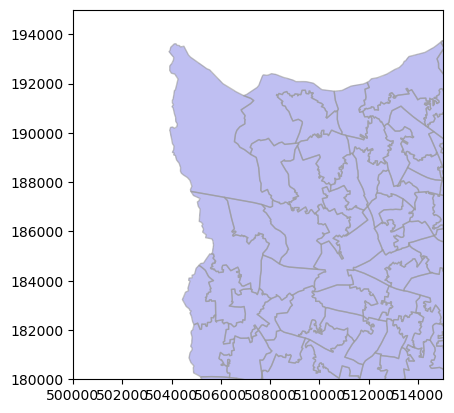

In [36]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.union_all())).rename(columns={0:'geometry'}).set_geometry("geometry")
ldn = ldn.set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .5))
msoas.plot(ax=ax, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

#### 5.2.2 A (Bad) First Join

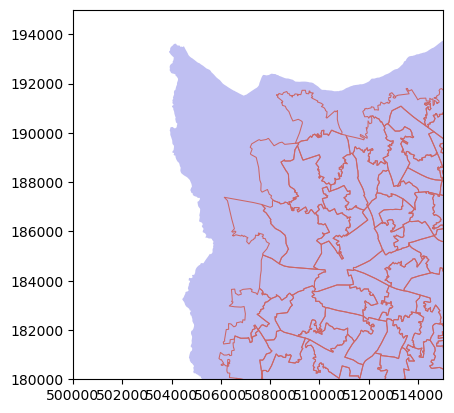

In [37]:
ldn_msoas = gpd.sjoin(msoas, ldn, predicate='within', how='inner')
ax = ldn.plot(facecolor=(.5, .5, .9, .5))
ldn_msoas.plot(ax=ax, facecolor='none', edgecolor=(.8, .4, .4), linewidth=0.75)
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

> **What has gone wrong???**
>
> Before you move on to the solution, stop and actually *think* about
> what this hasn’t done what you would have expected? THis is another
> reason that you need to pay attention to the differences between
> spatial and non-spatial joins.

#### 5.2.3 Buffer and Join

In order to ensure that we get all the MSOAs *within* London we need to
buffer the boundary by some amount to ensure that `within` returns what
we want. If *cover* were easier to use then that option might be
preferable.

##### 5.2.3.1 Question

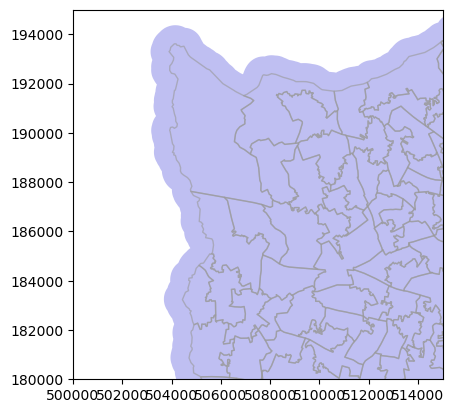

In [41]:
# buffer 缓冲操作，向外扩大100米
ldn['buffered'] = ldn.geometry.buffer(100)
ldn = ldn.set_geometry('buffered').set_crs(epsg=27700)
ax  = ldn.plot(facecolor=(.5, .5, .9, .5))
msoas.plot(ax=ax, facecolor='none', edgecolor=(.6, .6, .6, .6))
ax.set_xlim(500000, 515000)
ax.set_ylim(180000, 195000);

By default we want do an *inner* join because we want to drop everything
that doesn’t line up between the two data sets (i.e. don’t keep the
thousands of *other* non-London MSOAs).

##### 5.2.3.2 Question

<Axes: >

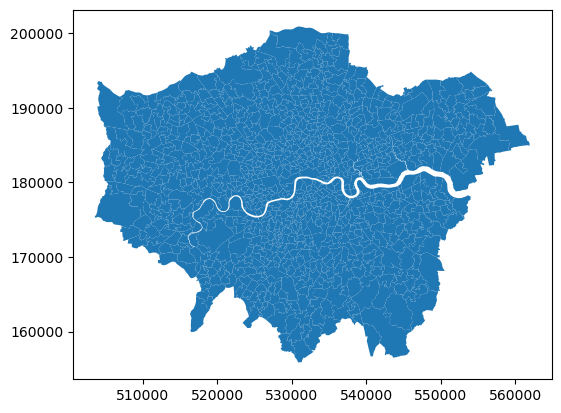

In [42]:
# predicate 参数指定两几何对象的空间关系
ldn_msoas = gpd.sjoin(msoas, ldn, predicate='within', how='inner')
ldn_msoas.plot()

##### 5.2.3.3 Important Note

If your plot above looks like the output from `pandas` and not
`geopandas` then the list of columns and the documentation for
`set_geometry` might help you to understand what is going wrong:

In [43]:
print(", ".join(ldn_msoas.columns.to_list()))

MSOA11CD, MSOA11NM, LAD11CD, LAD11NM, RGN11CD, RGN11NM, USUALRES, HHOLDRES, COMESTRES, POPDEN, HHOLDS, AVHHOLDSZ, geometry, index_right, geometry_right


It’s important to recognise that `join` and `sjoin` are *not* the same
even though they may effectively perform the same function. An issue can
arise if we join two *geodata* frames using the join function from
`pandas`. The latter doesn’t know anything about spatial data and we can
therefore ‘lose track’ of the geometry column. *Worse*, there are
actually two geometry columns now, so we need to tell Geopandas which
one to use!

The easiest way to do this is to simply rename the geometry we *want*
and then set is as the active geometry. Here’s the code to use if you
have a `geometry_left` column and aren’t able to show a map:

``` python
ldn_msoas = ldn_msoas.rename(columns={'geometry_left':'geometry'}).set_geometry('geometry')
ldn_msoas.drop(columns='geometry_right', inplace=True)
```

We also no longer really need to keep the full MSOA data set hanging
about.

In [44]:
try:
    del(msoas)
except NameError:
    print("msoas already deleted.")

##### 5.2.3.4 Question

-   Can you explain *why* the outputs of the `dissolve` and `union_all`
    *look* differnet? And use that as the basis for explaining why they
    *are* different?

> Answer 1

-   How do you know that the units for the buffering operation are
    metres? 250 could be *anything* right?

> Answer 2

-   Why do we need to buffer the London geometry *before* performing the
    *within* spatial join?

> Answer 3

### 5.3 Append or Derive Names

We don’t actually make use of these in this session, but *both*
operations could be relevant to your final reports:

1.  The Borough-to-Subregion mapping could help you to group your data
    into larger sets so that your resulst become more reobust. it also
    connects us to long-run patterns of socio-economic development in
    London.
2.  The MSOA Names data set (which you used above) gives you something
    that you could use to label one or more ‘neighbourhoods’ on a map
    with names that are *relevant*. So rather than talking about “As you
    can see, Sutton 003, is…”, you can write “The Wrythe neighbourhood
    \[or area\] of Sutton is significantly different from the
    surrounding areas…”

They also usefully test your understanding of regular expressions and a
few other aspects covered in previous weeks.

#### 5.3.1 Replace

You’ve done this before: notice that the MSOA Name *contains* the
Borough name **with a space and some digits at the end**. Use a regex
(in `str.replace()`) to extract the LA name from the MSOA name. See if
you do this *without* having to find your previous answer!

##### 5.3.1.1 Question

In [56]:
# 匹配空格和数字并用' '替换
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r' \d+$','',regex=True)

# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 13
print(ldn_msoas.Borough.unique())
print(f"There are {len(ldn_msoas.Borough.unique())} boroughs.")
print(f"Overall shape of data frame is {' x '.join([str(x) for x in ldn_msoas.shape])}")

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
There are 33 boroughs.
Overall shape of data frame is 983 x 16


#### 5.3.2 Map

Now that we’ve got the borough names we can set up a `mapping` dict here
so that we can apply it as part of the `groupby` operation below (you
should have 33 keys when done):

In [57]:
# 创建 mapping 字典，Borough名做键，值为所属区域分类
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))

33


##### 5.3.2.1 Question

In [59]:
# 通过 map() 将 mapping 中的 borough 映射值 所属区存储到新列
ldn_msoas['Subregion'] = ldn_msoas.Borough.map(mapping)

#### 5.3.3 And Save

In [60]:
ldn_msoas.to_parquet(os.path.join('data','geo','London_MSOA_Names.geoparquet'))

### 5.4 Load InsideAirbnb Data

In [61]:
listings = gpd.read_parquet( cache_data(f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet', ddir) ).to_crs(epsg=27700)
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

+ data/geo/20240614-London-listings.geoparquet found locally!
Data frame is 85,127 x 32


#### 5.4.1 Spatial Join

Associate LA (Local Authority) names to the listings using a spatial
join, but **notice** the `how` here:

##### 5.4.1.1 Question

In [62]:
gdf_la = gpd.sjoin(listings, boros, predicate='within', how='left')
print(gdf_la.columns.to_list())

['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month', 'geometry', 'index_right', 'NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER']


#### 5.4.2 Tidy Up

In [63]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

You’ll need to look closely to check that the `value_counts` output
squares with your expectations. If you don’t get `33` then there’s an
issue and you’ll need to run the code in
<a href="#sec-problems" class="quarto-xref">Section 5.4.3</a>:

In [64]:
if len(gdf_la.NAME.unique()) == 33:
    print("All good...")
else:
    print("Need to run the next section of code...")
    print(f"Now there are... {len(gdf_la.NAME.unique())} boroughs?")
    gdf_la.NAME.value_counts(dropna=False)

All good...


#### 5.4.3 Find Problematic Listings

If you were told that you need to run the next sectin of code then see
if you can work out what happened…

``` python
try:
    print(gdf_la[gdf_la.NAME.isna()].sample(2)[['name', 'NAME']])
    ax = gdf_la[gdf_la.NAME.isna()].plot(figsize=(9,6), markersize=5, alpha=0.5)
    boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);
except ValueError as e:
   pass
```

In short: in some cases there may be records that fall outside of London
because of Airbnb’s shuffling approach:

``` python
gdf_la.drop(index=gdf_la[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(f"Data frame is {gdf_la.shape[0]:,} x {gdf_la.shape[1]}")
```

#### 5.4.4 Check and Save

``` python
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(9,7))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);
```

You should get the following:

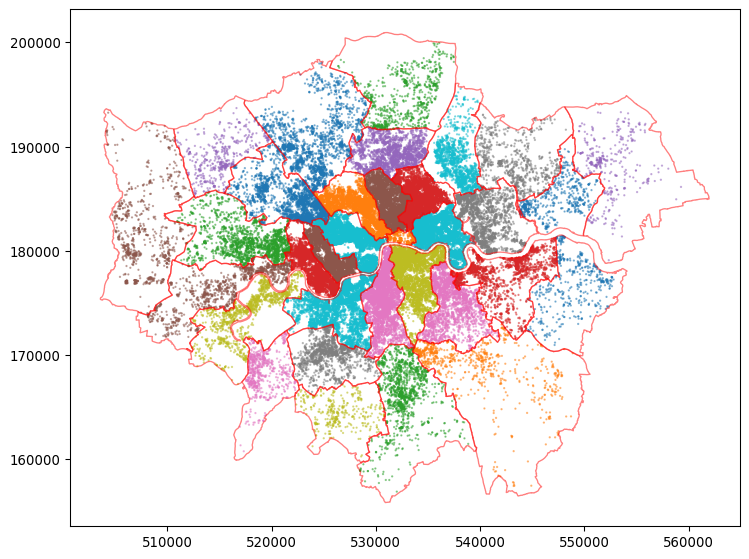

``` python
gdf_la.to_parquet(os.path.join('data','geo','Listings_with_LA.geoparquet'))
```

##### 5.4.4.1 Question

-   Do you understand the difference between `how='inner'` and
    `how='left'`?

> 

### 5.5 Create LA Data

Now that we’ve assigned every listing to a borough, we can derive
aggregate values for different groups of zones.

#### 5.5.1 Select LA

Select a LA that is relevant to *you* to explore further…

In [65]:
LA = 'Waltham Forest'

#### 5.5.2 Spatial Join

The first thing we want to do is join MSOA identifiers to each listing.
In both cases we want to constrain the data to only be for ‘our’ LA of
interest since that will speed up the process substantially:

In [66]:
gdf_msoa = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            ldn_msoas[ldn_msoas.Borough==LA][['MSOA11CD','MSOA11NM','USUALRES','HHOLDS','Subregion','geometry']], predicate='within')
gdf_msoa.head(2)

,index,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,...,reviews_per_month,geometry,NAME,GSS_CODE,index_right,MSOA11CD,MSOA11NM,USUALRES,HHOLDS,Subregion
0,37,41870,https://www.airbnb.com/rooms/41870,2023-09-07,Home in Walthamstow · 2 bedrooms · 1 bed · 2.5...,"Lovely friendly house, close to central line u...",182993,Bimpe,2010-07-27,"London, United Kingdom",...,0.01,POINT (538919.28 186290.652),Waltham Forest,E09000031,888,E02000921,Waltham Forest 027,11001,3966,Outer East and North East
1,90,78606,https://www.airbnb.com/rooms/78606,2023-09-07,Rental unit in Walthamstow · 1 bedroom · 1 pri...,"Comfortable, modern home with a friendly host ...",422362,Nicola,2011-03-04,"London, United Kingdom",...,0.04,POINT (539419.512 187953.652),Waltham Forest,E09000031,882,E02000915,Waltham Forest 021,8643,3305,Outer East and North East


#### 5.5.3 Aggregate

Now aggregate the data by MSOA, deriving median price and a count of the
listings:

In [67]:
grdf_msoa = gdf_msoa.groupby('MSOA11NM').agg(
    listing_count = ('price','count'),
    median_price = ('price','median')
).reset_index()
print(f"Have {grdf_msoa.shape[0]:,} rows and {grdf_msoa.shape[1]:,} columns")
grdf_msoa.head(2)

Have 28 rows and 3 columns


,MSOA11NM,listing_count,median_price
0,Waltham Forest 001,17,97.0
1,Waltham Forest 002,14,58.0


#### 5.5.4 Join (Again)

Here we see the **difference between merge and join**. You’ll notice
that `join` operates by taking one data frame as the implicit ‘*left*’
table (the one which *calls* join) while the one that is passed to the
join function is, implicitly, the ‘*right*’ table. Join operates only
using indexes, so you’ll need to insert the code to specify the same
index on both data frames, but this can be done **on-the-fly** as part
of the joining operation:

In [68]:
msoa_gdf = grdf_msoa.set_index('MSOA11NM').join(
                ldn_msoas[ldn_msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r').set_geometry('geometry')
msoa_gdf.head(3)

,listing_count,median_price,MSOA11CD,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,index_right,geometry_right,Borough,Subregion
MSOA11NM,,,,,,,,,,,,,,,,,,
Waltham Forest 001,17,97.0,E02000895,E09000031,Waltham Forest,E12000007,London,7979,7962,17,36.4,3271,2.4,"MULTIPOLYGON (((537919.442 195742.428, 538051....",0,"POLYGON ((528150.2 159979.2, 528100.9 160037.3...",Waltham Forest,Outer East and North East
Waltham Forest 002,14,58.0,E02000896,E09000031,Waltham Forest,E12000007,London,8814,8719,95,31.3,3758,2.3,"MULTIPOLYGON (((539172.688 195540, 539696.813 ...",0,"POLYGON ((528150.2 159979.2, 528100.9 160037.3...",Waltham Forest,Outer East and North East
Waltham Forest 003,7,89.0,E02000897,E09000031,Waltham Forest,E12000007,London,8077,7991,86,42.9,3345,2.4,"MULTIPOLYGON (((538862.624 194017.438, 539001....",0,"POLYGON ((528150.2 159979.2, 528100.9 160037.3...",Waltham Forest,Outer East and North East


``` python
msoa_gdf.plot(column='median_price', legend=True, figsize=(8,8));
```

You should get something like:

<Axes: >

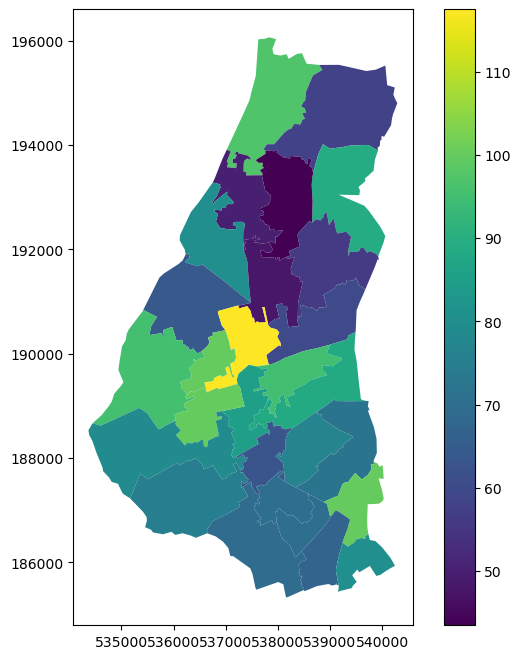

In [69]:
msoa_gdf.plot(column='median_price', legend=True, figsize=(8,8))

#### 5.5.5 Save

Just so that we can pick up here without having to re-run all the
preceding cells.

In [70]:
msoa_gdf.to_parquet(os.path.join('data','geo',f'{LA}-MSOA_data.geoparquet'))

##### 5.5.5.1 Question

-   Do you understand the differences between `pd.merge` and `df.join`?
    and `gpd.sjoin`?

> 

-   Do you understand why it may be necessary to `set_geometry` in some
    cases?

>